<a href="https://colab.research.google.com/github/Pratap8810/CS6910/blob/main/Assignemnt-3/Attention(5-6)/RNN_Attention_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving attention.py to attention.py


In [36]:
!pip install rich

In [37]:
import warnings
warnings.filterwarnings('ignore')

import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import seaborn as sns
from rich.progress import track
#from colorama import Fore,Style

import tensorflow as tf
from tensorflow import keras
import keras.backend as K
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Input,Dense,LSTM,GRU,RNN,SimpleRNN,Softmax,Dropout,Concatenate
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.callbacks import Callback, EarlyStopping

from tensorflow.keras import Model

from IPython.display import HTML as html_print
from IPython.display import display
from math import log
import math

In [38]:
class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            #de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_out_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>', U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)
            if verbose:
                print('Ws+Uh>', Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step,decoder_out_seq, [fake_state_e]
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step,e_outputs, [fake_state_c]
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]


<h2>Get the train, val and test Data</h2>

In [39]:
!wget https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar
!tar -xvf '/content/dakshina_dataset_v1.0.tar'

--2022-05-08 14:36:49--  https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.212.128, 172.217.214.128, 172.253.114.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.212.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2008340480 (1.9G) [application/x-tar]
Saving to: ‘dakshina_dataset_v1.0.tar.1’

dakshina_dataset_v1 100%[===================>]   1.87G   203MB/s    in 9.4s    

2022-05-08 14:36:58 (204 MB/s) - ‘dakshina_dataset_v1.0.tar.1’ saved [2008340480/2008340480]

dakshina_dataset_v1.0/bn/
dakshina_dataset_v1.0/bn/lexicons/
dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.test.tsv
dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.train.tsv
dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.dev.tsv
dakshina_dataset_v1.0/bn/native_script_wikipedia/
dakshina_dataset_v1.0/bn/native_script_wikipedia/bn.wiki-filt.valid.text.shu

In [40]:
train = '/content/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv'
val =   '/content/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.dev.tsv'
test =  '/content/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.test.tsv'

<h2> Preprocessing</h2>

In [41]:


#this functions extracts the initial data forom the training set provide
# it extracts ::::::
#num_encoder_tokens ,num_decoder_tokens ,
#input_token ,target_token ,reverse_input_token ,
#reverse_target_token,max_encoder_seq_length,max_decoder_seq_length
#
#the above are used further in different functions
def training_extract(path):
    input = []
    target = []
    input_chars = set()
    target_chars = set()
    with open(path, "r", encoding="utf-8") as f:
        lines = f.read().split("\n")
    for line in lines[: len(lines) - 1]:
      target_text,input_text, attestation = line.split("\t")
      # We use "tab" as the "start sequence" character
      # for the targets, and "\n" as "end sequence" character.
      input.append(input_text)
      target.append("\t" + target_text + "\n")
      for char in input_text:
        if char not in input_chars:
          input_chars.add(char)
      for char in target_text:
        if char not in target_chars:
          target_chars.add(char)
    target_chars.add("\t")
    target_chars.add("\n")
    input_characters = sorted(list(input_chars))
    target_characters = sorted(list(target_chars))
    num_encoder_tokens = len(input_characters)
    num_decoder_tokens = len(target_characters)
    max_encoder_seq_length = max([len(txt) for txt in input])
    max_decoder_seq_length = max([len(txt) for txt in target])
    input_token = dict([(char, i) for i, char in enumerate(input_characters)])
    target_token = dict([(char, i) for i, char in enumerate(target_characters)])

    reverse_input_token = dict((i, char) for char, i in input_token.items())
    reverse_target_token = dict((i, char) for char, i in target_token.items())

    return num_encoder_tokens ,num_decoder_tokens ,input_token ,target_token ,reverse_input_token ,reverse_target_token,max_encoder_seq_length,max_decoder_seq_length


#from here we extract based on the path provided
#the following are extracted 
#input and output (training or test or validation)
#encoder_input_data
#decoder_input_data
#decoder_target_data
def extract_data(path,max_encoder_seq_length,max_decoder_seq_length, num_decoder_tokens):
  input = []
  target = []
  
  with open(path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
  for line in lines[: len(lines) - 1]:
    target_text,input_text, attestation = line.split("\t")
    input.append(input_text)
    target.append("\t" + target_text + "\n")
    
    
  encoder_input_data = np.zeros((len(input), max_encoder_seq_length), dtype="float32")
  decoder_input_data = np.zeros((len(input), max_decoder_seq_length), dtype="float32")
  decoder_target_data = np.zeros((len(input),max_decoder_seq_length, num_decoder_tokens), dtype="float32")

  
  for i, (input_text, target_text) in enumerate(zip(input, target)):
    for t, char in enumerate(input_text):
      encoder_input_data[i][t] = input_token[char]
    for t, char in enumerate(target_text):
      decoder_input_data[i][t] = target_token[char]
      if t > 0:
        decoder_target_data[i, t - 1, target_token[char]] = 1.0
  
  return (input ,target ,encoder_input_data,decoder_input_data,decoder_target_data)



<h4> extract features from train data</h4>

In [42]:
d=training_extract(train)
print(d)
num_encoder_tokens =d[0]
num_decoder_tokens=d[1]
input_token=d[2]
target_token=d[3]
reverse_input_token=d[4]
reverse_target_token=d[5]
max_encoder_seq_length=d[6]
max_decoder_seq_length=d[7] 

(26, 65, {'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24, 'z': 25}, {'\t': 0, '\n': 1, 'ँ': 2, 'ं': 3, 'ः': 4, 'अ': 5, 'आ': 6, 'इ': 7, 'ई': 8, 'उ': 9, 'ऊ': 10, 'ऋ': 11, 'ए': 12, 'ऐ': 13, 'ऑ': 14, 'ओ': 15, 'औ': 16, 'क': 17, 'ख': 18, 'ग': 19, 'घ': 20, 'ङ': 21, 'च': 22, 'छ': 23, 'ज': 24, 'झ': 25, 'ञ': 26, 'ट': 27, 'ठ': 28, 'ड': 29, 'ढ': 30, 'ण': 31, 'त': 32, 'थ': 33, 'द': 34, 'ध': 35, 'न': 36, 'प': 37, 'फ': 38, 'ब': 39, 'भ': 40, 'म': 41, 'य': 42, 'र': 43, 'ल': 44, 'व': 45, 'श': 46, 'ष': 47, 'स': 48, 'ह': 49, '़': 50, 'ा': 51, 'ि': 52, 'ी': 53, 'ु': 54, 'ू': 55, 'ृ': 56, 'ॅ': 57, 'े': 58, 'ै': 59, 'ॉ': 60, 'ो': 61, 'ौ': 62, '्': 63, 'ॐ': 64}, {0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'j', 10: 'k', 11: 'l', 12: 'm', 13: 'n', 14: 'o', 15: 'p', 16: 'q', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v

<h4> Vectorize the train,val,test data</h4>

In [43]:
en_ip_tr_text ,de_ip_tr_text , en_ip_tr_data , de_ip_tr_data , de_op_tr_data  = extract_data(train,max_encoder_seq_length,max_decoder_seq_length, num_decoder_tokens)
en_ip_val_text ,de_ip_val_text , en_ip_val_data , de_ip_val_data , de_op_val_data  =extract_data(val,max_encoder_seq_length,max_decoder_seq_length, num_decoder_tokens)
en_ip_ts_text ,de_ip_ts_text , en_ip_ts_data , de_ip_ts_data , de_op_ts_data  = extract_data(test,max_encoder_seq_length,max_decoder_seq_length, num_decoder_tokens)

print("Train data shape : ",en_ip_tr_data.shape)
print("Validation data shape : ",en_ip_val_data.shape)
print("Test data shape : ",en_ip_ts_data.shape)
 


Train data shape :  (44204, 20)
Validation data shape :  (4358, 20)
Test data shape :  (4502, 20)


# <h2>Callback for getting word level accuracy of validation data</h2>

In [44]:

def beam_search_decoder(data, k):
    decodedWords = [[list(), 0.0]]
    # walk over each step in sequence
    for word in data:
      candidates = list()
      # expand each current candidate
      for sequence in decodedWords:
        seq, score = sequence
        for j in range(len(word)):
          candidate = [seq + [j], score - log(word[j])]
          candidates.append(candidate)
      # order all candidates by score
      ordered = sorted(candidates, key=lambda a:a[1])
      # select k best
      decodedWords = ordered[:k]
    return decodedWords
  
#translating the word back based on the number seqyence given
def translate(word):
  sentence = [] 
  for i in word:
    char = reverse_target_token[i]
    sentence.append(char)
  return "".join(sentence)





In [45]:

class WordAccuracyCallback(keras.callbacks.Callback):
  def __init__(self,beam_size):
    self.beam_size=beam_size
  def on_epoch_end(self, epoch, logs=None):
    pred=self.model.predict([en_ip_val_data,de_ip_val_data])
    count=0
    for i in range(pred.shape[0]):
      pSequences=beam_search_decoder(pred[i],self.beam_size)
      for j in range(self.beam_size):
        if "\t"+translate(pSequences[j][0][:len(de_ip_val_text[i])-1])==de_ip_val_text[i]:
          count=count+1
          break
    factor = 10.0 ** 4
    logs["WordAccuracy"]=math.trunc((count/pred.shape[0])*factor)/factor
    print("- wordAccuracy:",logs["WordAccuracy"])

**Question 5 (20 Marks) : Now add an attention network to your basis sequence to sequence model and train the model again. For the sake of simplicity you can use a single layered encoder and a single layered decoder (if you want you can use multiple layers also). Please answer the following questions:**

<h2>Model Class</h2>

In [46]:
class RNN_Model:

  def __init__(self,embed_size ,no_of_en_layers,no_of_de_layers,latent_dimension,dropout,rec_drop,cell_type,beam_size):

    
    self.no_of_en_layers = no_of_en_layers
    self.no_of_de_layers = no_of_de_layers

    self.latent_dimension = latent_dimension
    
    self.cell_type=cell_type
    self.model = None
    self.dropout = dropout
    self.rec_drop=rec_drop
    #used to store all the encoder layers and dec layers..
    self.encoder_layers = None
    self.decoder_layers = None


    #the inference model..
    self.encoder_model = None
    self.decoder_model = None

    #for beam search and greedysearch
    self.beam_size=beam_size
    self.embed_size = embed_size
  def BUILD_FIT_MODEL(self, en_ip_tr_data , de_ip_tr_data , de_op_tr_data,epochs ,batch_size,max_encoder_seq_length,num_encoder_tokens,max_decoder_seq_length,num_decoder_tokens):

    #Define the encoder Model..
    encoder_inputs = Input(shape=(max_encoder_seq_length,))
    embd_en_ip = Embedding(input_dim = num_encoder_tokens,output_dim = self.embed_size ,
                            input_length=max_encoder_seq_length ,name='embd_en_layer')(encoder_inputs)

    out = embd_en_ip
    encoder_states = []
    self.encoder_layers = []

    for j in range(self.no_of_en_layers):

      
      if self.cell_type == 'LSTM':
        self.encoder_layers.append(
            LSTM(self.latent_dimension,return_state=True, return_sequences=True ,recurrent_dropout=self.rec_drop,dropout=self.dropout))
        

      elif self.cell_type == 'GRU':
        self.encoder_layers.append(
            GRU(self.latent_dimension,return_state=True, return_sequences=True ,recurrent_dropout=self.rec_drop,dropout=self.dropout))

      elif self.cell_type == 'RNN':
        self.encoder_layers.append(
            SimpleRNN(self.latent_dimension,return_state=True,
                      return_sequences=True ,recurrent_dropout=self.rec_drop,dropout=self.dropout))
      
      all_op = self.encoder_layers[-1](out)
      out = all_op[0]
      encoder_states +=[all_op[1:]]
  
    encoder_outputs=out

    #Define The Decoder Model:
    decoder_inputs = Input(shape=(max_decoder_seq_length,))
    embd_de_ip = Embedding(input_dim = num_decoder_tokens,output_dim = self.embed_size,
                            input_length=max_decoder_seq_length ,name='embd_de_layer')(decoder_inputs)

    outputs = embd_de_ip
    self.decoder_layers = []

    for j in range(self.no_of_de_layers):
      if self.cell_type == 'LSTM':
        self.decoder_layers.append(LSTM(self.latent_dimension,
                                       return_sequences=True, return_state=True ,recurrent_dropout=self.rec_drop,dropout=self.dropout))
      
      elif self.cell_type == 'GRU':
        self.decoder_layers.append(GRU(self.latent_dimension,
                                       return_sequences=True, return_state=True ,recurrent_dropout=self.recur_drop,dropout=self.dropout))
      
      elif self.cell_type == 'RNN':
        self.decoder_layers.append(SimpleRNN(self.latent_dimension,
                                       return_sequences=True, return_state=True ,recurrent_dropout=self.rec_drop,dropout=self.dropout))
      
      all_op = self.decoder_layers[-1](outputs, initial_state = encoder_states[j])
      outputs, dstates = all_op[0],all_op[1:]

    decoder_outputs=outputs

    attn_layer = AttentionLayer(name='attention')
    attn_out, attn_states = attn_layer([encoder_outputs,decoder_outputs])

    decoder_concat_input = Concatenate(axis=-1, name='concat')([decoder_outputs, attn_out])
    dense = Dense(num_decoder_tokens, activation='softmax', name='dense_layer')

    dense_time = TimeDistributed(dense, name='time_distributed_layer')
    decoder_pred = dense_time(decoder_concat_input)

    self.model = keras.Model([encoder_inputs, decoder_inputs], decoder_pred)
    self.model.compile(optimizer='adam',loss='categorical_crossentropy' , metrics=['accuracy'])
    self.model.fit(
        [en_ip_tr_data, de_ip_tr_data],
        de_op_tr_data,
        batch_size=batch_size,
        epochs=epochs,
        shuffle=True,
        callbacks = [WordAccuracyCallback(self.beam_size)],verbose=1)

    return



<h2> Inference Class</h2>

In [55]:
class Inference:

  def __init__(self,parent_model,max_encoder_seq_length,max_decoder_seq_length,target_token,
               reverse_target_token,latent_dimension,encoder_layers,decoder_layers,cell_type,num_en_layers,num_de_layers):

    self.model = parent_model
    self.max_encoder_seq_length = max_encoder_seq_length
    self.max_decoder_seq_length = max_decoder_seq_length
    self.target_token = target_token
    self.reverse_target_token = reverse_target_token
    self.latent_dimension = latent_dimension
    self.encoder_layers = encoder_layers
    self.decoder_layers = decoder_layers
    self.cell_type = cell_type
    self.num_en_layers = num_en_layers
    self.num_de_layers = num_de_layers
    self.encoder_model = None
    self.decoder_model = None


  def build_inference_model(self):

    batch_size = 1

    #Define the Encoder Model..
    encoder_inf_inputs = Input(batch_shape = (batch_size,self.max_encoder_seq_length))
    op  = self.model.get_layer('embd_en_layer')(encoder_inf_inputs)
    enc_inf_states = []

    #pass this input to each enc layer from the model and get the final op...
    for j in range(self.num_en_layers):
      all_out = self.encoder_layers[j](op)
      op = all_out[0]
      enc_inf_states+=[all_out[1:]]
    
    #encoder ops for all time steps (for the last enc layer only..)
    encoder_inf_states = Input(batch_shape = (batch_size,self.max_encoder_seq_length,self.latent_dimension))
    #producing 1 finalop from encoder and layers 
    self.encoder_model = Model(encoder_inf_inputs, [op,enc_inf_states])

    #Define the Decoder Model..
    decoder_inf_inputs = Input(batch_shape = (batch_size ,1))
    op = self.model.get_layer('embd_de_layer')(decoder_inf_inputs)

    dec_init_states = []
    dec_inf_states = []
    num_states = 1
    if self.cell_type == 'LSTM':
      num_states = 2

    for j in range(self.num_de_layers):
      #attach the ip state of corresponding encoder..
      dec_init_state = [Input(batch_shape=(batch_size,self.latent_dimension)) for _ in range(num_states)]

      all_out = self.decoder_layers[j](op , initial_state = dec_init_state)
      op = all_out[0] 

      dec_init_states+= [dec_init_state]
      dec_inf_states+=[all_out[1:]]

    
    #apply attention layer to the last decoder layer op and last encoderlayer op...
    attn_inf_out, attn_inf_states = self.model.get_layer('attention')([encoder_inf_states, op])

    #concatenate att_out and dec_out..
    decoder_inf_concat = Concatenate(axis = -1,name='concat')([op , attn_inf_out])

    #dense_layer = self.model.get_layer('dense_layer')
    decoder_inf_pred = self.model.get_layer('time_distributed_layer')(decoder_inf_concat)

    self.decoder_model = Model(inputs = [encoder_inf_states,dec_init_states,decoder_inf_inputs],
                      outputs = [decoder_inf_pred,attn_inf_states,dec_inf_states])
    
    return 

  #function will return the decoded seq and attention matrix for a given word..
  def decode_sequence(self,input):
    # Encode the input as state vectors.
    en_op , states = self.encoder_model.predict(input)
    # Generate empty target sequence of length 1.
    get_seq = np.zeros((1, 1))
    # Populate the first character of target sequence with the start character rank.
    get_seq[0][0] = self.target_token['\t']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    sentence = []  #Creating a list then using "".join() is usually much faster for string creation
    att_mtx = []
    
    while True:

      out = self.decoder_model.predict([en_op,states,get_seq])

      output_tokens, att_weights, states = out[0], out[1], out[2]

      # Sample a token
      token_index = np.argmax(output_tokens[0, 0])
      char = self.reverse_target_token[token_index]
      sentence.append(char)

      #collect the attention weights
      att_mtx.append(att_weights)
      # Exit condition: either hit max length
      # or find stop character.
      if char == '\n' or len(sentence) > self.max_decoder_seq_length:
          break

      # Update the target sequence (of length 1).
      get_seq[0][0] = token_index
      
    
    return ("".join(sentence),sentence,att_mtx)

  #given test data returns the predictions made by the model..
  def get_predictions(self,ip_data,op_text):

    n=len(ip_data)
    predictions = []
    num_correct = 0

    for i in track(range(n)):
      input = ip_data[i:i+1]
      word=self.decode_sequence(input)[0]

      if word[-1]=='\n':
        word = word[:-1]

      predictions+=[word]
      #excluding the '\t and \n'
      true_word = op_text[i][1:-1]
      #getting word level accuracy...
      num_correct+=(word == true_word)

    acc = num_correct/n
    return (acc,predictions)

<h2> Train the model</h2>

<h4>Select the best hyperparameters and train the model</h4>

In [35]:
parent = RNN_Model(embed_size = 128,
                 no_of_en_layers = 2,
                 no_of_de_layers = 2,
                 latent_dimension = 256,
                 dropout = 0,
                 rec_drop = 0,
                 cell_type = 'LSTM',
                 beam_size=3)

parent.BUILD_FIT_MODEL(en_ip_tr_data,
               de_ip_tr_data,
               de_op_tr_data,
               20,
               32,
               max_encoder_seq_length ,
               num_encoder_tokens ,
               max_decoder_seq_length , 
               num_decoder_tokens
               )


Epoch 1/20
1382/1382 [==============================] - 244s 160ms/step - loss: 0.5055 - accuracy: 0.2010 - WordAccuracy: 0.3923
Epoch 2/20
1382/1382 [==============================] - 211s 153ms/step - loss: 0.1791 - accuracy: 0.2881 - WordAccuracy: 0.5133
Epoch 3/20
1382/1382 [==============================] - 206s 149ms/step - loss: 0.1414 - accuracy: 0.2994 - WordAccuracy: 0.5585
Epoch 4/20
1382/1382 [==============================] - 210s 152ms/step - loss: 0.1195 - accuracy: 0.3066 - WordAccuracy: 0.5353
Epoch 5/20
1382/1382 [==============================] - 217s 157ms/step - loss: 0.1040 - accuracy: 0.3115 - WordAccuracy: 0.5557
Epoch 6/20
1382/1382 [==============================] - 212s 153ms/step - loss: 0.0905 - accuracy: 0.3160 - WordAccuracy: 0.5603
Epoch 7/20
1382/1382 [==============================] - 209s 151ms/step - loss: 0.0780 - accuracy: 0.3200 - WordAccuracy: 0.5713
Epoch 8/20
1382/1382 [==============================] - 212s 154ms/step - loss: 0.0676 - accuracy

<h2>Run inference for Test Data for best model</h2>

In [56]:
io = Inference(parent_model = parent.model,
               max_encoder_seq_length = max_encoder_seq_length ,
               max_decoder_seq_length = max_decoder_seq_length,
               target_token = target_token,
               reverse_target_token = reverse_target_token,
               latent_dimension = parent.latent_dimension,
               encoder_layers = parent.encoder_layers,
               decoder_layers = parent.decoder_layers,
               cell_type = parent.cell_type,
               num_en_layers = parent.no_of_en_layers,
               num_de_layers = parent.no_of_de_layers
               )
io.build_inference_model()

<h4>Inference for some sample test datapoints</h4>

In [ ]:
ridx = np.random.choice(len(en_ip_ts_text),100,replace=False)

for seq_index in ridx:
    st=seq_index
    en=st+1
    input_seq = en_ip_ts_data[st:en]
    decoded_sentence,char_by_char,att_mtx = io.decode_sequence(input_seq)
    print(Style.BRIGHT + Fore.RED +'index_no :',st)
    print(Style.BRIGHT + Fore.BLACK +'Input word:', en_ip_ts_text[st])
    print(Style.BRIGHT + Fore.BLUE +'Decoded word:', decoded_sentence)
    print(Style.BRIGHT + Fore.GREEN +'True word:', de_ip_ts_text[st])
    print(Style.BRIGHT + Fore.BLACK +'--'*10)

index_no : 1841
Input word: dikhayi
Decoded word: दिखाई

True word: 	दिखायी

--------------------
index_no : 3441
Input word: ria
Decoded word: आरए

True word: 	रिया

--------------------
index_no : 1979
Input word: naksalavaad
Decoded word: नक्सलवाद

True word: 	नक्सलवाद

--------------------
index_no : 298
Input word: aabantit
Decoded word: आबांतित

True word: 	आबंटित

--------------------
index_no : 1444
Input word: jain
Decoded word: जैन

True word: 	जैन

--------------------
index_no : 4384
Input word: slidon
Decoded word: स्लिडों

True word: 	स्लाइडों

--------------------
index_no : 577
Input word: error
Decoded word: एरोर

True word: 	एरर

--------------------
index_no : 2022
Input word: narbhakshi
Decoded word: नार्भक्षी

True word: 	नरभक्षी

--------------------
index_no : 1549
Input word: trubyunal
Decoded word: ट्रब्यूनल

True word: 	ट्रिब्यूनल

--------------------
index_no : 1363
Input word: jimme
Decoded word: जीम्मे

True word: 	जिम्मे

--------------------
index_no : 3

**Q5.b Evaluate your best model on the test set and report the accuracy. Also upload all the predictions on the test set in a folder predictions_attention on your github project.**

In [57]:
acc , predictions = io.get_predictions(en_ip_ts_data,de_ip_ts_text)
print('Accuracy For Test Data Using Attention :',acc)


Output()

Accuracy For Test Data Using Attention : 0.3411816970235451


In [58]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [62]:
import csv

truth_value=[]
predicted_value =[]

with open('/content/drive/MyDrive/prediction_attention.csv', mode='w') as file:
  fieldnames = ['text', 'truth value', 'predicted value']
  writer = csv.DictWriter(file, fieldnames=fieldnames)
  writer.writeheader()
  for i in range(len(predictions)):
    writer.writerow({'text':en_ip_ts_text[i],"truth value":de_ip_ts_text[i],'predicted value':predictions[i]})

<h4>Visualizing long words and their predictions</h4>

**Q5.(c) Does the attention based model perform better than the vanilla model? If so, can you check some of the errors that this model corrected and note down your inferences (i.e., outputs which were predicted incorrectly by your best seq2seq model are predicted correctly by this model)**

<h5>upload the ttf file</h5>

In [ ]:
!pip install wandb

In [61]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
wandb.init(project="Assignment-3")

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Nirmala.ttf to Nirmala.ttf


In [ ]:
def Plot_Words(index_list,predictions,ip_text,true_text,title):
  font_prop = FontProperties(fname = '/Nirmala.ttf',size=15)

  # Creating 2 subplots
  fig, axs = plt.subplots(1, len(index_list),figsize=(14,3))
 
  # Accessing each axes object to plot the data through returned array
  for i in range(len(index_list)):
    axs[i].get_xaxis().set_visible(False)
    axs[i].get_yaxis().set_visible(False)
    axs[i].text(0.2,0.2,true_text[index_list[i]][1:-1],fontsize = 20,
                fontproperties = font_prop,bbox={'facecolor': 'olive', 'alpha': 0.5, 'pad': 10})
    
    axs[i].text(0.2,0.5,ip_text[index_list[i]],fontsize = 10)
    
    axs[i].text(0.2,0.7,predictions[i],fontsize = 20,
                fontproperties = font_prop,bbox={'facecolor': 'orange', 'alpha': 0.5, 'pad': 10})
    

  plt.suptitle(title)
  plt.show()

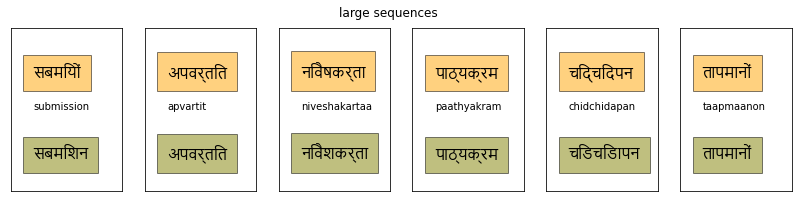

In [ ]:
long_index_nos= [4069,121,2114,2303,1143,1699]

long_index_predictions = []
for i in long_index_nos:
  dec_seq = io.decode_sequence(en_ip_ts_data[i:i+1])[0]
  if dec_seq[-1]=='\n':
    dec_seq = dec_seq[:-1]
  long_index_predictions.append(dec_seq)

Plot_Words(long_index_nos ,long_index_predictions,en_ip_ts_text,de_ip_ts_text,'large sequences')

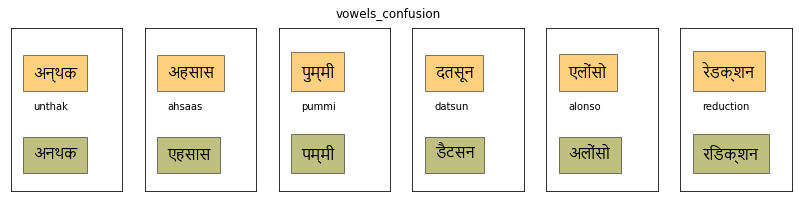

In [ ]:
vowel_conf_idx = [90,602,2232,1619,194,3438]
vowel_conf_predictions = []
for i in vowel_conf_idx:
  dec_seq = io.decode_sequence(en_ip_ts_data[i:i+1])[0]
  if dec_seq[-1]=='\n':
    dec_seq = dec_seq[:-1]
  vowel_conf_predictions.append(dec_seq)
Plot_Words(vowel_conf_idx,vowel_conf_predictions,en_ip_ts_text,de_ip_ts_text,'vowels_confusion')

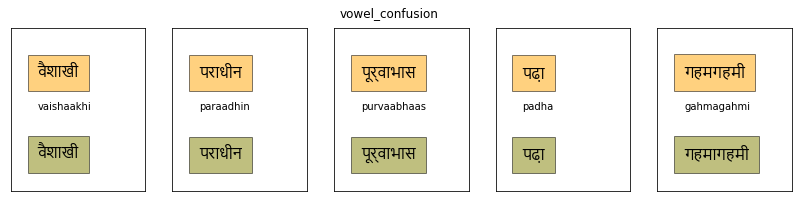

In [ ]:
aa_conf_idx = [3872,2241,2411,2216,976]
aa_conf_predictions = []
for i in aa_conf_idx:
  dec_seq = io.decode_sequence(en_ip_ts_data[i:i+1])[0]
  if dec_seq[-1]=='\n':
    dec_seq = dec_seq[:-1]
  aa_conf_predictions.append(dec_seq)
Plot_Words(aa_conf_idx,aa_conf_predictions,en_ip_ts_text,de_ip_ts_text,'vowel_confusion')

**5.(d) In a 3 x 3 grid paste the attention heatmaps for 10 inputs from your test data (read up on what are attention heatmaps).**

In [ ]:
def plot_attention_grid(en_ip_ts_text,en_ip_ts_data,io,ttf_path):

  random.seed(10)
  font_prop = FontProperties(fname = ttf_path,size=15)

  ridx = np.random.choice(len(en_ip_ts_text),9,replace=False)
  ix=1
  plt.figure(figsize=(20,15))
  plt.tight_layout()
  for idx in ridx:
    ax = plt.subplot(3,3,ix)
    input_seq = en_ip_ts_data[idx:idx+1]
    decoded_sentence,char_by_char,att_mtx = io.decode_sequence(input_seq)
    source = en_ip_ts_text[idx].split()

    input_chars = [c for c in en_ip_ts_text[idx]]
    mtx = []

    for i in range(len(char_by_char)):
      mtx.append(att_mtx[i][0][0][:len(input_chars)])

    sns.heatmap(mtx,cmap='Blues',cbar=False)
    loc,labels = plt.xticks()
    plt.xticks(loc,input_chars,fontsize=15)
    loc,labels = plt.yticks()
    plt.yticks(loc,char_by_char,fontproperties = font_prop ,rotation=50)
    #plt.ylabel(decoded_sentence,fontproperties = font_prop)

    ix+=1
  plt.suptitle('Attention Heatmaps',fontsize = 20)
  plt.show()

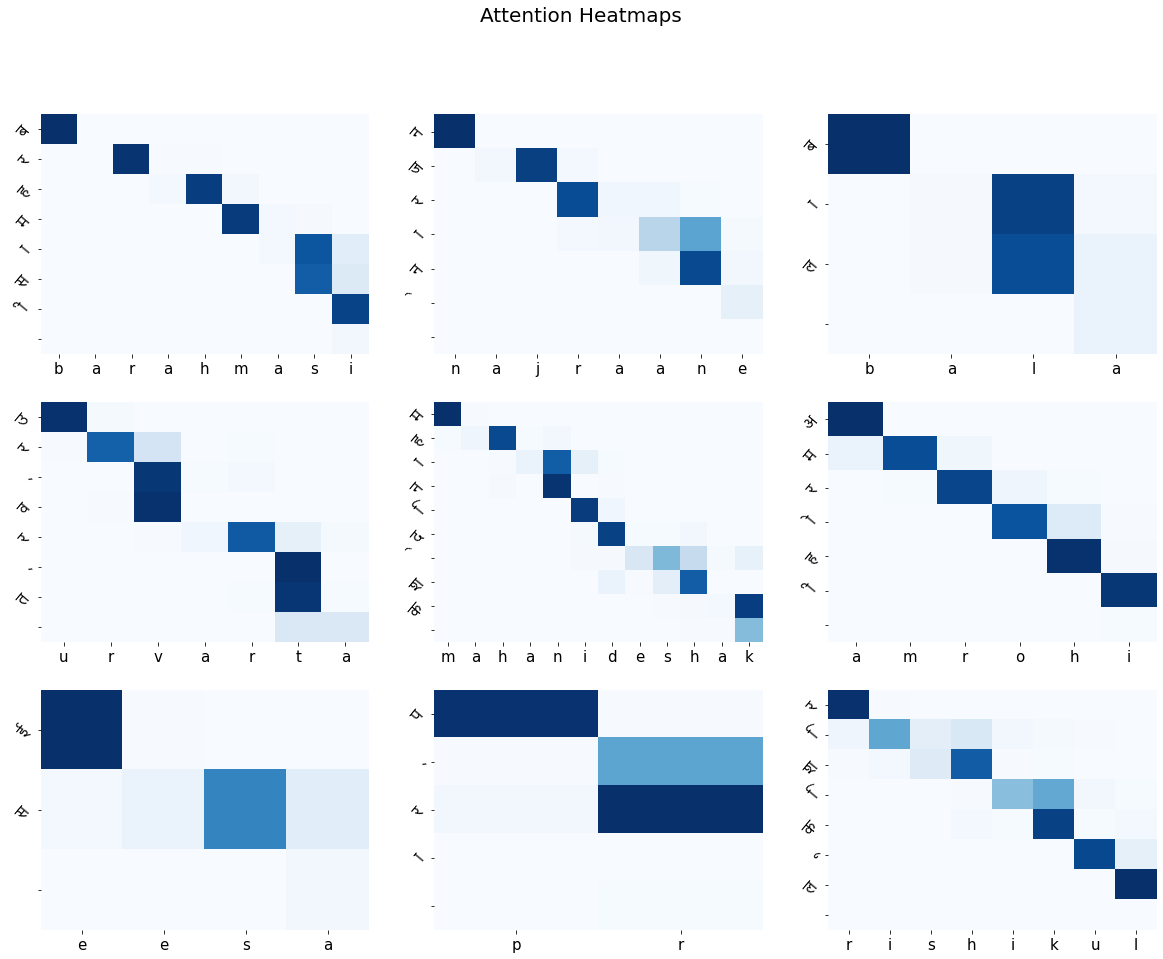

In [ ]:
ttf_path = '/content/Nirmala.ttf'
plot_attention_grid(en_ip_ts_text,en_ip_ts_data,io,ttf_path)

<h2>Visualization</h2>

**Q6.This a challenge question and most of you will find it hard.**

**I like the visualisation in the figure captioned "Connectivity" in this article. Make a similar visualisation for your model. Please look at this blog for some starter code. The goal is to figure out the following: When the model is decoding the iii-th character in the output which is the input character that it is looking at?**

In [ ]:
def cstr(s, color='black'):
	if s == ' ':
		return "<text style=color:#000;padding-left:10px;background-color:{}> </text>".format(color, s)
	else:
		return "<text style=color:#000;background-color:{}>{} </text>".format(color, s)
	
# print html
def print_color(t):
  display(html_print(''.join([cstr(ti, color=ci) for ti,ci in t])))

# get appropriate color for value
def get_clr(value):
  colors = ['#85c2e1', '#89c4e2', '#95cae5', '#99cce6', '#a1d0e8'
		'#b2d9ec', '#baddee', '#c2e1f0', '#eff7fb', '#f9e8e8',
		'#f9e8e8', '#f9d4d4', '#f9bdbd', '#f8a8a8', '#f68f8f',
		'#f47676', '#f45f5f', '#f34343', '#f33b3b', '#f42e2e']
  value = int((value * 100) / 5)
  
  return colors[value]

# sigmoid function
def sigmoid(x):
	z = 1/(1 + np.exp(-x)) 
	return z

In [ ]:
def visualize(input_seq,a):
  for i in range(len(char_by_char[:-1])):
    text_colours = []
    print(char_by_char[i])
    for j in range(len(input_seq)):
      text = (input_seq[j], get_clr(a[i][j]))
      text_colours.append(text)
    print_color(text_colours)

In [ ]:
random.seed(11)
ridx = np.random.choice(len(en_ip_ts_text),9,replace=False)

for i in ridx:
  st=i
  input_seq = en_ip_ts_data[st:st+1]
  decoded_sentence,char_by_char,att_mtx = io.decode_sequence(input_seq)
  #print('Input word:', en_ip_ts_text[st])
  #print('Target sentence:', target_test_texts[st])
  #print('Predicted chars:', char_by_char)
  #print('Decoded word:', decoded_sentence)
  mtx=[]
  input_chars = [c for c in en_ip_ts_text[st]]
  for i in range(len(char_by_char)):
    output_matrix=(att_mtx[i][0][0][:len(input_chars)])
    output_matrix=sigmoid(output_matrix)
    mtx.append(output_matrix)
  a = np.array(mtx)
  visualize(en_ip_ts_text[st],a)
  print("--"*10)

द


ू


ं


ग


र


प


ु


र


--------------------
न


े


व


े


द


्


य


--------------------
ध


ु


ं


ध


--------------------
अ


च


य


ू


त


--------------------
प


ू


र


्


व


ा


भ


ा


स


--------------------
प


्


र


ो


प


े


ल


े


ं


ट


--------------------
ब


ा


ग


ि


य


ो


ं


--------------------
स


ु


ध


ा


र


ग


्


र


ह


--------------------
ब


्


र


ा


व


ो


--------------------
